# UNet Image Segmentation. Version 2

[Original video](https://youtu.be/IHq1t7NxS8k)

[Paper walkthrough](https://youtu.be/oLvmLJkmXuc)

[Paper](https://arxiv.org/abs/1505.04597)

![U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

## Importing libraries

In [ ]:
import os
import cv2
import torch
import random
import shutil
import torchvision
import numpy as np
import torch.nn as nn
import multiprocessing
import albumentations as A
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms.functional as TF


from tqdm import tqdm
# from tqdm.notebook import tqdm
from PIL import Image
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader


# Set random seed for reproducibility. Results should be the same all the time.
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

## Getting previously saved model file

In [ ]:
# Mount your Google Drive to this Colab
from google.colab import drive

gdrive = '/content/gdrive'
drive.mount(gdrive)

# Check connection
data_dir = f'{gdrive}/My Drive/Colab Notebooks/2025.07.25_execises/models'

# Show files in a data directory
!ls -hal "{data_dir}"

Mounted at /content/gdrive
total 1.9G
-rw------- 1 root root  16M Jul 28 11:26 3d_image_classification.keras
-rw------- 1 root root 249M Aug 12 12:49 brisc2025.zip
-rw------- 1 root root  32M Jul 30 16:32 dcgan_discriminator_celeb.pth.tar
-rw------- 1 root root  32M Jul 30 16:32 dcgan_discriminator_checkpoint.pth.tar
-rw------- 1 root root  41M Jul 30 16:32 dcgan_generator_celeb.pth.tar
-rw------- 1 root root 145M Jul 30 16:32 dcgan_generator_checkpoint.pth.tar
-rw------- 1 root root 239M Sep  2  2018 maps.tar.gz
-rw------- 1 root root  32M Aug  7 18:24 pix2pix_discriminator.pth.tar
-rw------- 1 root root 623M Aug  7 18:24 pix2pix_generator.pth.tar
-rw------- 1 root root 129M Aug 11 13:57 ResNet18_checkpoint.pth.tar
-rw------- 1 root root 1.2M Jul 29 08:44 simple_gan_discriminator_checkpoint.pth.tar
-rw------- 1 root root 2.6M Jul 29 08:44 simple_gan_generator_checkpoint.pth.tar
-rw------- 1 root root 356M Aug 14 09:23 UNet_Brisc.pth.tar


In [ ]:
# Get previourly saved model

import os

MODEL_NAME = 'UNet'
CHECKPOINT_FILE = f'{MODEL_NAME}_Brisc.pth.tar'  # name of pre-trained model checkpoint
DATASET_NAME = 'brisc2025.zip'

# Copy files from Google Drive
if os.path.exists(f'{data_dir}/{CHECKPOINT_FILE}'):
    !cp -rf '{data_dir}/{CHECKPOINT_FILE}'   '.'
    !ls -hal '{CHECKPOINT_FILE}'

# Copy dataset from Google Drive
if os.path.exists(f'{data_dir}/{DATASET_NAME}'):
    !cp -rf '{data_dir}/{DATASET_NAME}'   '.'
    !ls -hal '{DATASET_NAME}'

-rw------- 1 root root 356M Aug 14 10:26 UNet_Brisc.pth.tar
-rw------- 1 root root 249M Aug 14 10:26 brisc2025.zip


## Getting dataset from Kaggle

Download [BRISC 2025](https://www.kaggle.com/datasets/briscdataset/brisc2025) dataset from Kaggle.

BRISC is a high-quality, expert-annotated MRI dataset curated for brain tumor segmentation and classification. It addresses common limitations in existing datasets (e.g., BraTS, Figshare), including class imbalance, narrow tumor focus, and annotation inconsistencies.

<br />

But first, authorize on [Kaggle](https://www.kaggle.com/settings) and get `kaggle.json` file, which is a crucial component for interacting with the Kaggle API.

   * On [Kaggle Setting](https://www.kaggle.com/settings) web page press "Create new token" button.
   
   * Ensure `kaggle.json` file is in the location `~/.kaggle/kaggle.json` to use the API.

   * Save your personal `kaggle.json` file and use it in this Google Colab.

In [ ]:
from google.colab import files

if not os.path.exists(DATASET_NAME):
    if not os.path.exists('kaggle.json'):
        # Upload YOUR PERSONAL `kaggle.json` file
        uploaded = files.upload()

        # Retrieve uploaded file and print results
        for fn in uploaded.keys():
            print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
            os.rename(fn, 'kaggle.json')

        # Then copy kaggle.json into the folder where the API expects to find it.
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !ls -hal ~/.kaggle

    # BRISC 2025: Brain Tumor MRI Dataset for Segmentation and Classification
    competition_name = 'briscdataset/brisc2025'
    !kaggle datasets list -s "{competition_name}"
    # !kaggle datasets files "{competition_name}"
    !kaggle datasets download "{competition_name}"

In [ ]:
# Extract data
import zipfile
import tarfile

def extract(fname):
    if fname.endswith(".tar.gz") or fname.endswith('.tgz'):
        ref = tarfile.open(fname, mode='r:gz')
    elif fname.endswith('.tar'):
        ref = tarfile.open(fname, mode='r:')
    elif fname.endswith('.tar.bz2') or fname.endswith('.tbz'):
        ref = tarfile.open(fname, mode='r:bz2')
    elif fname.endswith('.zip'):
        ref = zipfile.ZipFile(fname, mode='r')

    ref.extractall()
    ref.close()

extract('brisc2025.zip')

In [ ]:
images_dir = '/content/brisc2025/segmentation_task/test/images/'
masks_dir  = '/content/brisc2025/segmentation_task/test/masks/'
image_name = 'brisc2025_test_00001_gl_ax_t1.jpg'
mask_name  = 'brisc2025_test_00001_gl_ax_t1.png'

image = np.array(Image.open(images_dir + image_name))
mask = np.array(Image.open(masks_dir + mask_name), dtype=np.float32)
print(f'min: {np.min(image)}; max: {np.max(image)}; shape: {image.shape}')  # [0, 255]
print(f'min: {np.min(mask)}; max: {np.max(mask)}; shape: {mask.shape}')  # [0.0, 255.0]

min: 0; max: 255; shape: (512, 512, 3)
min: 0.0; max: 255.0; shape: (512, 512)


In [ ]:
class  BriscDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.images[index])
        mask_path = os.path.join(self.masks_dir, self.images[index].replace('.jpg', '.png'))
        image = np.array(Image.open(img_path))  # [0, 255]
        if len(image.shape) == 2:  # image shape is (512, 512)
            image = image[:, :, np.newaxis].repeat(3, axis=2)  # convert 2D to 3D array
        mask = np.array(Image.open(mask_path), dtype=np.float32)  # [0.0, 255.0]
        mask = mask / np.max(mask)  # normalize to [0.0, 1.0]

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image, mask = augmentations['image'], augmentations['mask']

        return image, mask

## Setting global variables

In [ ]:
NUM_WORKERS = multiprocessing.cpu_count()
print(f"Number of CPU kernels: {NUM_WORKERS}")

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
USE_CUDA = torch.cuda.is_available()  # check if CUDA is available

# Neural network hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 14  # from 14 to 16
NUM_EPOCHS = 5  # 50
PATIENCE = 5  # how long to wait after the last best improvement before stopping
IMAGE_HEIGHT = IMAGE_WIDTH = 512
PIN_MEMORY = True

TRAIN_IMG_DIR  = '/content/brisc2025/segmentation_task/train/images/'
TRAIN_MASK_DIR = '/content/brisc2025/segmentation_task/train/masks/'
TEST_IMG_DIR   = '/content/brisc2025/segmentation_task/test/images/'
TEST_MASK_DIR  = '/content/brisc2025/segmentation_task/test/masks/'

Number of CPU kernels: 2


## UNet model architecture

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of U-Net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of U-Net
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # reverse list

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_conn = skip_connections[idx//2]

            if x.shape != skip_conn.shape:
                x = TF.resize(x, size=skip_conn.shape[2:])

            concat_skip = torch.cat((skip_conn, x), dim=1)  # batch x channel x h x w
            x = self.ups[idx+1](concat_skip)  # double conv

        return self.final(x)


def test():
    x = torch.randn((16, 3, 299, 299))
    model = UNET(in_channels=3, out_channels=1)
    preds = model(x)
    print(preds.shape)
    assert preds.shape == (16, 1, 299, 299)


test()

torch.Size([16, 1, 299, 299])


## Helper functions

In [ ]:
LOAD_MODEL = True  # load pre-trained model from the file

TOTAL_EPOCHS = 0  # total number of train epochs
BEST_SCORE = 0  # best Dice score obtained
TRAIN_HISTORY = {  # previous train history
    "train_scores": [],
    "train_losses": [],
    "test_scores": [],
    "test_losses": [],
}

CHECKPOINT = {  # set checkpoint dictionary
    "model_state_dict": None,  # model.state_dict() - weights and other information
    "optimizer_state_dict": None,  # optimizer.state_dict() - optimizer information
    "total_epochs": TOTAL_EPOCHS,  # current epoch number
    "best_score": BEST_SCORE,  # current best score
    "train_history": TRAIN_HISTORY,  # current train history
}


def save_checkpoint(checkpoint, checkpoint_file):
    torch.save(checkpoint, checkpoint_file)
    print(" => Save checkpoint")


def load_checkpoint(checkpoint_file, model, optimizer):
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    total_epochs = checkpoint["total_epochs"]
    best_score = checkpoint["best_score"]
    train_history = checkpoint["train_history"]
    print(f" => Load checkpoint. Epochs: {total_epochs}. "
          f"Score: {best_score:.2f}%")
    return total_epochs, best_score, train_history


def get_loaders(train_dir, train_maskdir, test_dir, test_maskdir, batch_size,
                train_transform, test_transform,
                num_workers=multiprocessing.cpu_count(), pin_memory=True):

    train_ds = BriscDataset(images_dir=train_dir, masks_dir=train_maskdir,
                            transform=train_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              num_workers=num_workers,
                              pin_memory=pin_memory, shuffle=True)

    test_ds = BriscDataset(images_dir=test_dir, masks_dir=test_maskdir,
                           transform=test_transform)

    test_loader = DataLoader(test_ds, batch_size=batch_size,
                             num_workers=num_workers,
                             pin_memory=pin_memory, shuffle=False)

    return train_loader, test_loader


def dice_score(preds, masks, calculate_loss=False):
    smooth = 1e-5
    if calculate_loss:  # for loss `preds` should be tensor
        pass
    else:  # for scale `preds` should be float number
        preds = (preds > 0.5).float()
    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice


def dice_loss(preds, masks):
    return 1 - dice_score(preds, masks, calculate_loss=True)


def save_predictions_as_imgs(loader, model, folder='saved_images', device='cuda'):
    os.makedirs(folder, exist_ok=True)
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))  # prediction (0, 1)
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f'{folder}/pred_{idx}.jpg')
        torchvision.utils.save_image(y.unsqueeze(1), f'{folder}/{idx}.jpg')
    model.train()


def plot_score(train_scores, test_scores):
    """ Plot scores curves. """
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_scores)), train_scores, label="Training Score")
    plt.plot(range(len(test_scores)), test_scores, label="Validation Score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.title(f"Best Dice score for {MODEL_NAME} is {BEST_SCORE:.2f}% "
              f'in {TOTAL_EPOCHS} epochs')
    plt.savefig(f"{MODEL_NAME}_score_plot.png")
    plt.show()


def plot_loss(train_losses, test_losses):
    """ Plot loss curves. """
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
    plt.plot(range(len(test_losses)), test_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss for {MODEL_NAME}")
    plt.savefig(f"{MODEL_NAME}_loss_plot.png")
    plt.show()

## Train

In [ ]:
def check_score(loader, model, device='cuda'):
    num_correct, num_pixels, d_score, num_loss = 0, 0, 0.0, 0.0

    model.eval()  # switch to evaluation mode
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1)  # (N, h, w) ==> (N, 1, h, w)
            preds = torch.sigmoid(model(images))

            # `*.item()` means store scalar value, not the tensor
            num_loss += dice_loss(preds, masks).item() * images.size(0)  # get loss
            d_score += dice_score(preds, masks).item()  # get score

    mean_score = d_score / len(loader) * 100
    mean_loss = num_loss / len(loader.dataset)
    model.train()  # switch to train mode

    return mean_score, mean_loss




def train(loader, model, optimizer, scaler, epoch, num_epochs):
    d_score, num_loss = 0.0, 0.0

    # progress bar
    loop = tqdm(enumerate(loader), total=len(loader), leave=False)
    loop.set_description(f'Epoch [{epoch}/{TOTAL_EPOCHS + NUM_EPOCHS}]')

    for batch_idx, (images, masks) in loop:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE).unsqueeze(1)  # (N, h, w) ==> (N, 1, h, w)

        # forward
        with torch.autocast(DEVICE, dtype=torch.float16):
            preds = torch.sigmoid(model(images))

            loss = dice_loss(preds, masks)  # get loss
            num_loss += loss.item() * images.size(0)  # get loss
            d_score += dice_score(preds, masks).item()  # get score

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    mean_score = d_score / len(loader) * 100
    mean_loss = num_loss / len(loader.dataset)
    return mean_score, mean_loss




def main():
    train_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),

        # Apply 1 of the 8 possible D4 dihedral group transformations
        # to a square-shaped input
        A.D4(p=1.0),

        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ])

    test_transform = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ])

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Load previously saved model.
    if LOAD_MODEL and os.path.exists(CHECKPOINT_FILE):
        TOTAL_EPOCHS, BEST_SCORE, TRAIN_HISTORY = load_checkpoint(
            CHECKPOINT_FILE, model, optimizer)
    else:
        TOTAL_EPOCHS = 0
        BEST_SCORE = 0.0
        TRAIN_HISTORY = {
            "train_scores": [],
            "train_losses": [],
            "test_scores": [],
            "test_losses": [],
        }

    train_loader, test_loader = get_loaders(
        TRAIN_IMG_DIR, TRAIN_MASK_DIR,
        TEST_IMG_DIR, TEST_MASK_DIR, BATCH_SIZE,
        train_transform, test_transform,
        NUM_WORKERS, PIN_MEMORY)

    scaler = torch.amp.GradScaler(enabled=USE_CUDA)

    model.train()  # switch the model to train mode
    no_improvement_count = 0  # number of epochs with no improvement

    # Initialize train and test scores and loses for prots.
    train_scores = []
    train_losses = []
    test_scores = []
    test_losses = []

    for epoch in range(TOTAL_EPOCHS + 1, TOTAL_EPOCHS + NUM_EPOCHS + 1):
        train_score, train_loss = train(train_loader, model, optimizer,
                                        scaler, epoch, NUM_EPOCHS)
        train_scores.append(train_score)
        train_losses.append(train_loss)

        test_score, test_loss = check_score(test_loader, model, device=DEVICE)
        test_scores.append(test_score)
        test_losses.append(test_loss)

        message = (f'Epoch: {epoch} from {TOTAL_EPOCHS + NUM_EPOCHS}. '
                   f'Loss: {test_loss:.5f}. '
                   f'Dice-score: {test_score:.2f}%')

        if BEST_SCORE < test_score:
            print(message, end="")
            no_improvement_count = 0
            BEST_SCORE = test_score
            TOTAL_EPOCHS = epoch
            TRAIN_HISTORY["train_scores"] += train_scores
            TRAIN_HISTORY["train_losses"] += train_losses
            TRAIN_HISTORY["test_scores"] += test_scores
            TRAIN_HISTORY["test_losses"] += test_losses
            CHECKPOINT = {
                "model_state_dict": model.state_dict(),  # weights and other information
                "optimizer_state_dict": optimizer.state_dict(),  # optimizer information
                "total_epochs": TOTAL_EPOCHS,  # current epoch number
                "best_score": BEST_SCORE,  # current best score
                "train_history": TRAIN_HISTORY,  # current train history
            }
            save_checkpoint(CHECKPOINT, CHECKPOINT_FILE)
            # Re-initialize train and test scores and loses
            train_scores = []
            train_losses = []
            test_scores = []
            test_losses = []

            # # save examples
            # save_predictions_as_imgs(
            #     test_loader, model,folder='saved_images', device=DEVICE)

        else:  # no improvement
            print(message)
            no_improvement_count += 1
            # Exit from training if no improvement for "patience" epoch.
            if no_improvement_count >= PATIENCE:
                print(f"Stopping early as no improvement has been observed"
                    f"in {PATIENCE} epochs.")
                break  # exit from the cycle

    # Clear memory (RAM) before exit from this function
    torch.cuda.empty_cache()
    del(train_loader)
    del(test_loader)

In [ ]:
main()

 => Load checkpoint. Epochs: 3. Score: 79.71%


Dice-score: 78.16%


Dice-score: 79.29%


Dice-score: 80.94% => Save checkpoint


Dice-score: 80.90%


Dice-score: 79.63%


## Check neural network score

 => Load checkpoint. Epochs: 2. Score: 80.94%


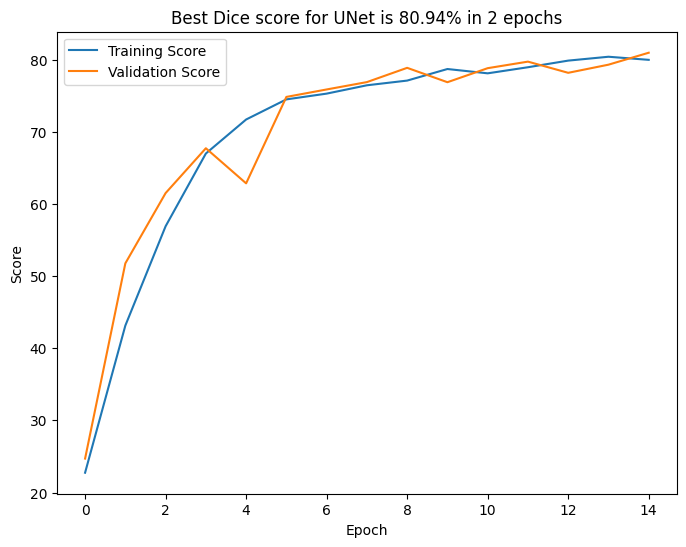

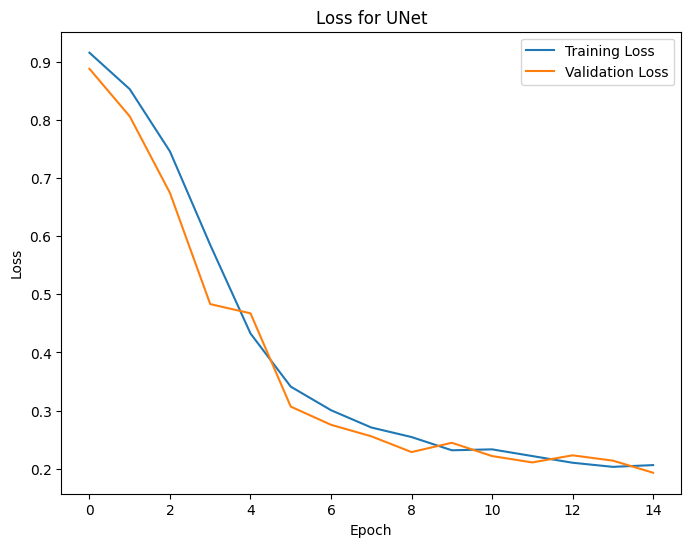

In [ ]:
# Load checkpoint
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

TOTAL_EPOCHS, BEST_SCORE, TRAIN_HISTORY = load_checkpoint(
        CHECKPOINT_FILE, model, optimizer)

# Get training history from the checkpoint
train_scores = TRAIN_HISTORY["train_scores"]
train_losses = TRAIN_HISTORY["train_losses"]
test_scores = TRAIN_HISTORY["test_scores"]
test_losses = TRAIN_HISTORY["test_losses"]

# Show training history
plot_score(train_scores, test_scores)
plot_loss(train_losses, test_losses)

Training history. Date: 14.08.2025.

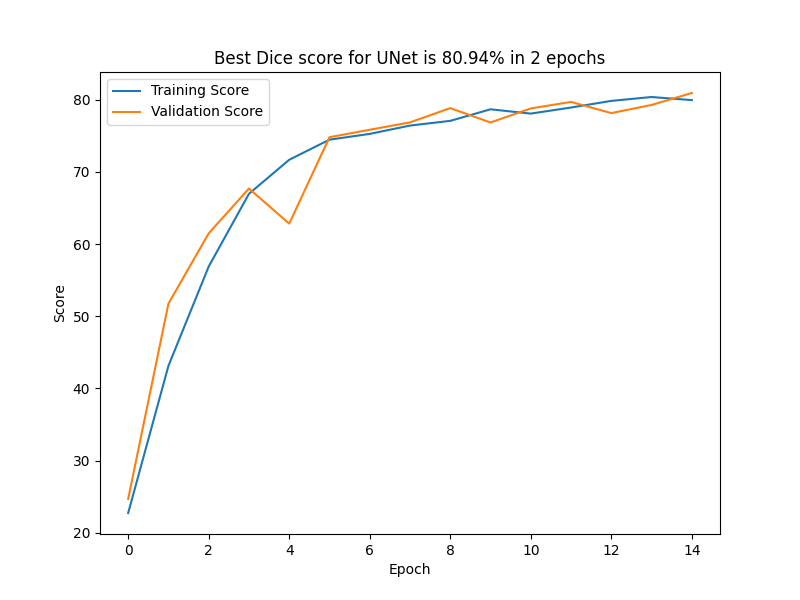

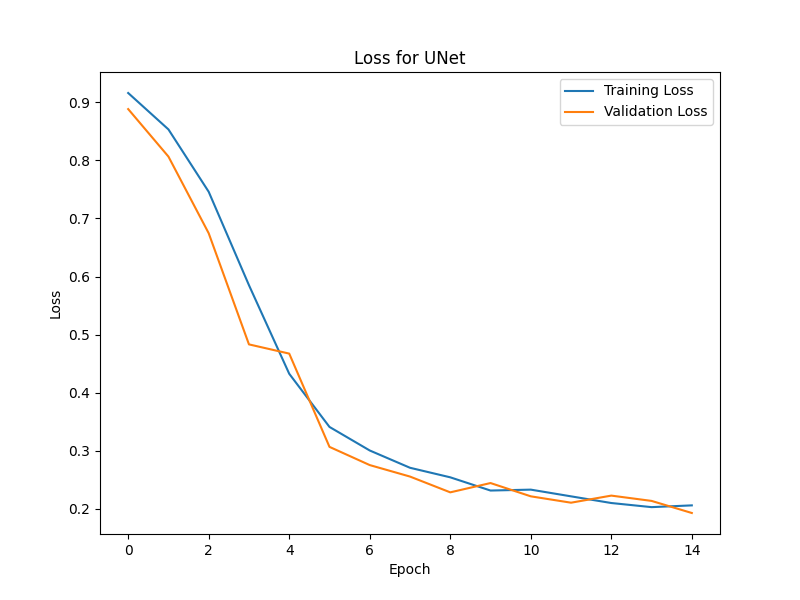

## Visualize results

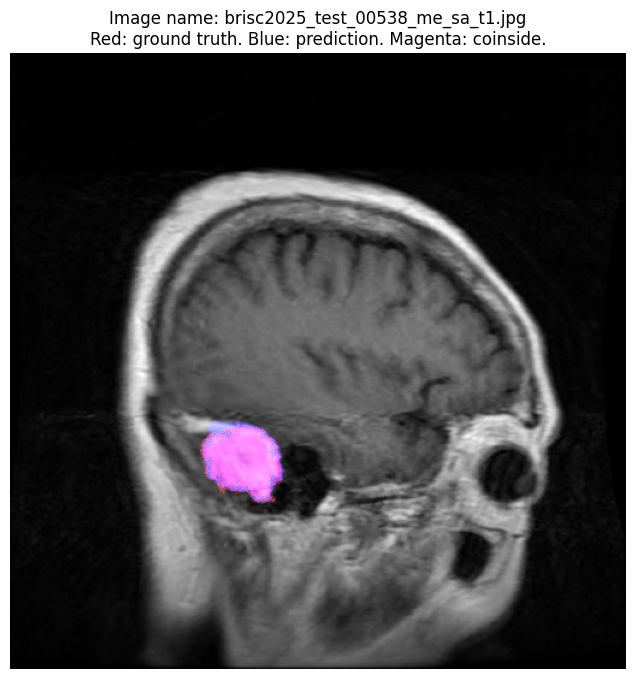

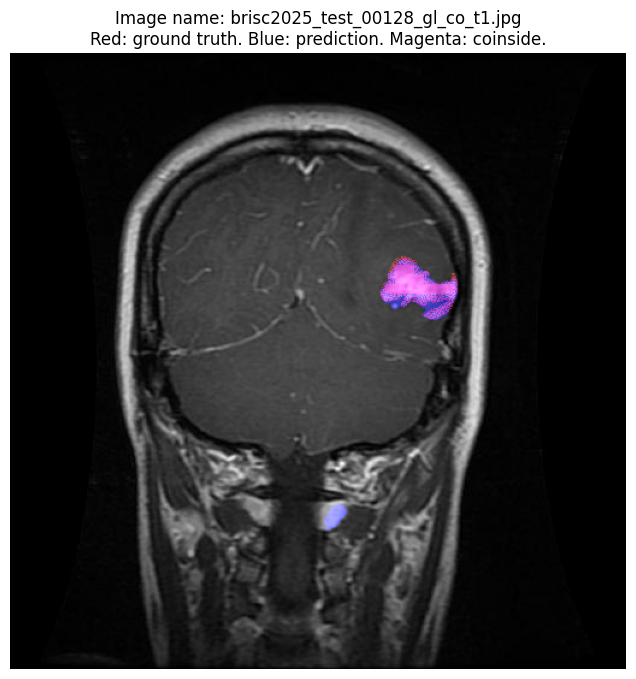

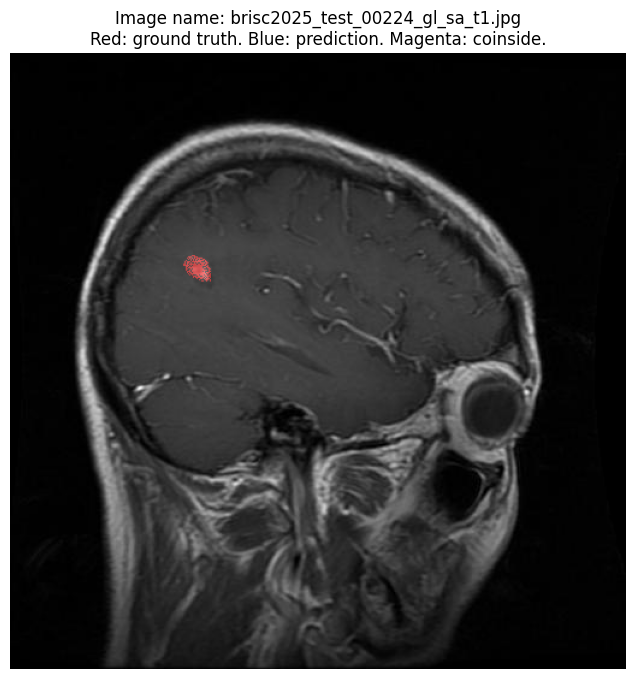

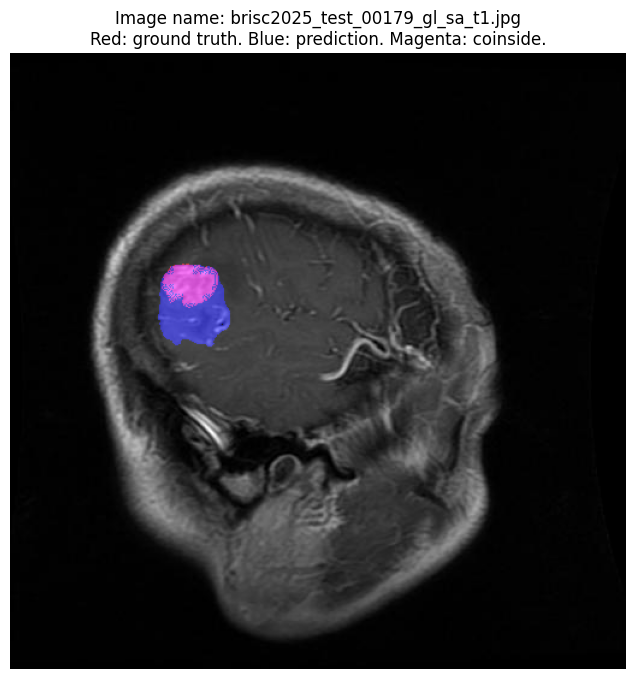

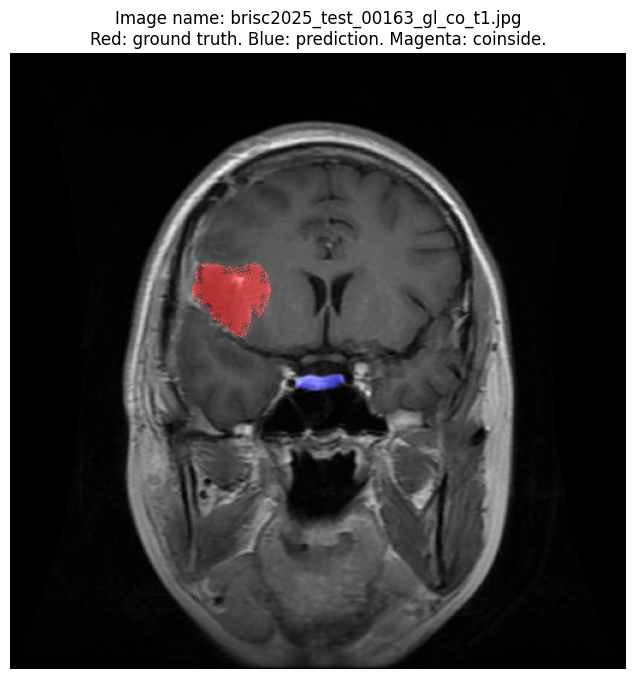

In [ ]:
def get_image_and_mask(index, list_files, transform):
    img_path = os.path.join(TEST_IMG_DIR, list_files[index])
    mask_path = os.path.join(TEST_MASK_DIR, list_files[index].replace('.jpg', '.png'))
    image = np.array(Image.open(img_path))  # [0, 255]
    if len(image.shape) == 2:  # image shape is (512, 512)
        image = image[:, :, np.newaxis].repeat(3, axis=2)  # (512, 512) -> (512, 512, 3)
    mask = np.array(Image.open(mask_path), dtype=np.float32)  # [0.0, 255.0]
    mask = mask / np.max(mask)  # normalize to [0.0, 1.0]

    augmentations = transform(image=image, mask=mask)
    image, mask = augmentations['image'], augmentations['mask']

    return image, mask  # get PyTorch tensors


def pytorch_to_numpy(image):
    """ Convert PyTorch tensor to NumPy array. """
    image = image.cpu().detach().numpy()  # move tensor to CPU and convert to NumPy
    image = np.squeeze(image, axis=0)  # convert (1, C, H, W) to (C, H, W)

    # For RGB images (C, H, W) -> (H, W, C)
    if image.ndim == 3 and image.shape[0] == 3:  # if RGB
        image = np.transpose(image, (1, 2, 0))  # (3, H, W) -> (H, W, 3)

    # For grayscale images with a channel dimension (1, H, W) -> (H, W) -> (H, W, 3)
    if image.ndim == 3 and image.shape[0] == 1:  # if grayscale
        image = np.squeeze(image, axis=0)  # (1, H, W) -> (H, W)
        image = image[:, :, np.newaxis].repeat(3, axis=2)  # (H, W) -> (H, W, 3)

    return image  # NumPy array shape is (H, W, 3)


def show(image, mask, pred, size=(8, 8), title=None):
    """ Show image in Jupyter Notebook. """
    image = pytorch_to_numpy(image)
    mask = pytorch_to_numpy(mask)[:, :, 0]  # extract only one channel for mask
    pred = pytorch_to_numpy(pred)[:, :, 0]

    # Un-normalize
    mean = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    std = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    image = (image * std + mean) * 255.0  # [-1.0, +1.0] -> [0.0, 255.0]
    # Clip values to ensure they are within [0, 255] and convert to uint8
    image = np.clip(image, 0, 255).astype(np.uint8)

    # Create a colored overlay for the mask
    mask_color = (255, 0, 0)  # red color for ground truth
    pred_color = (0, 0, 255)  # blue color for prediction
    alpha = 0.5  # transparency level

    # Create a colored version of the mask
    colored_mask = np.zeros_like(image, dtype=np.uint8)
    colored_pred = np.zeros_like(image, dtype=np.uint8)
    colored_mask[mask == 1.0] = mask_color
    colored_pred[pred == 1.0] = pred_color

    # Overlay the colored mask on the original image
    overlayed_image = cv2.addWeighted(image, 1, colored_mask, alpha, 0)
    overlayed_image = cv2.addWeighted(overlayed_image, 1, colored_pred, alpha, 0)

    plt.figure(figsize=size)  # set image size in inches
    plt.title(title)
    plt.imshow(overlayed_image, cmap='viridis')
    plt.axis("off")  # turn off axis numbers
    plt.show



destin_dir = './visualization'

if os.path.exists(destin_dir):
    shutil.rmtree(destin_dir)  # remove directory and all its files
os.makedirs(destin_dir, exist_ok=True)  # create directory

list_files = os.listdir(TEST_IMG_DIR)  # get list of all files in directory

test_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
    ToTensorV2(),
])

for i in range(5):
    fname = list_files[i]  # file name
    if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        savepath = os.path.join(destin_dir, f'{MODEL_NAME}_{fname}')
        image, mask = get_image_and_mask(i, list_files, test_transform)

        model.eval()  # switch to evaluation mode
        with torch.no_grad():
            image = image.to(DEVICE).unsqueeze(0)  # (3, h, w) ==> (1, 3, h, w)
            mask = mask.to(DEVICE).unsqueeze(0).unsqueeze(0)  # (h, w) ==> (1, 1, h, w)
            pred = torch.sigmoid(model(image))
            pred = (pred > 0.5).float()  # True/False ==> 1.0/0.0
        model.train()  # switch to train mode

        title = (f'Image name: {fname}\n'
                 f'Red: ground truth. Blue: prediction. Magenta: coinside.')
        show(image, mask, pred, title=title)

Resulting images. Date 14.08.2025.

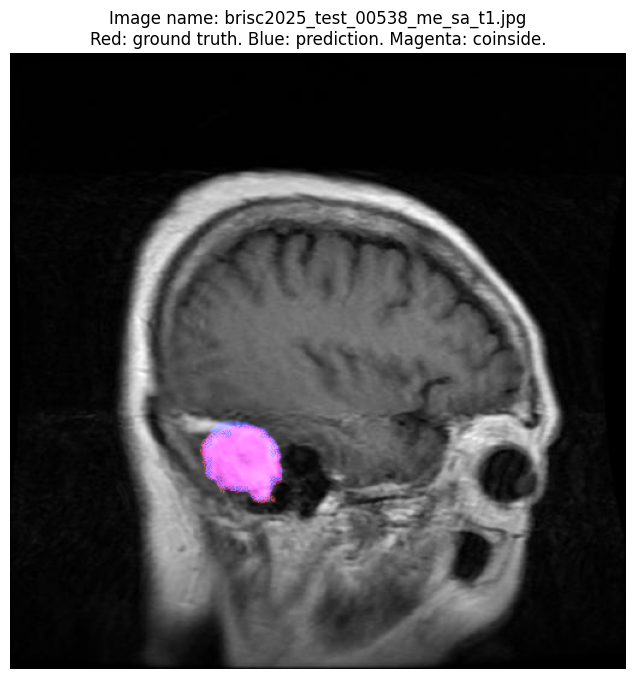

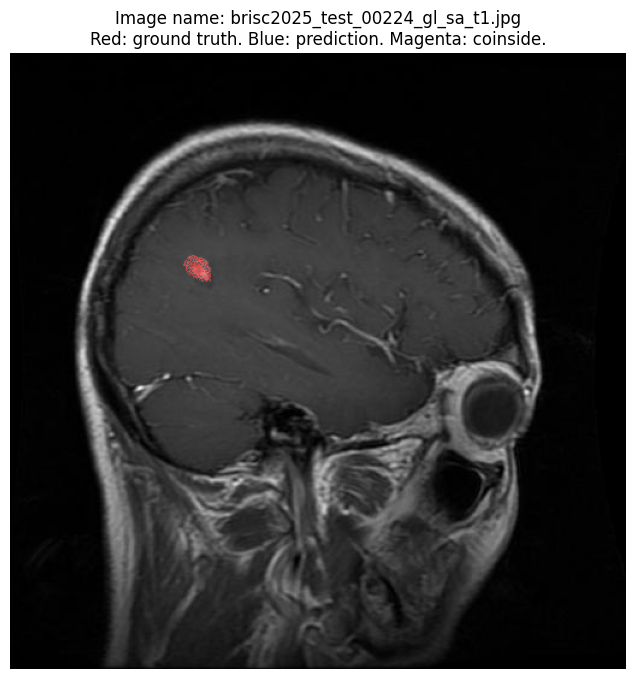

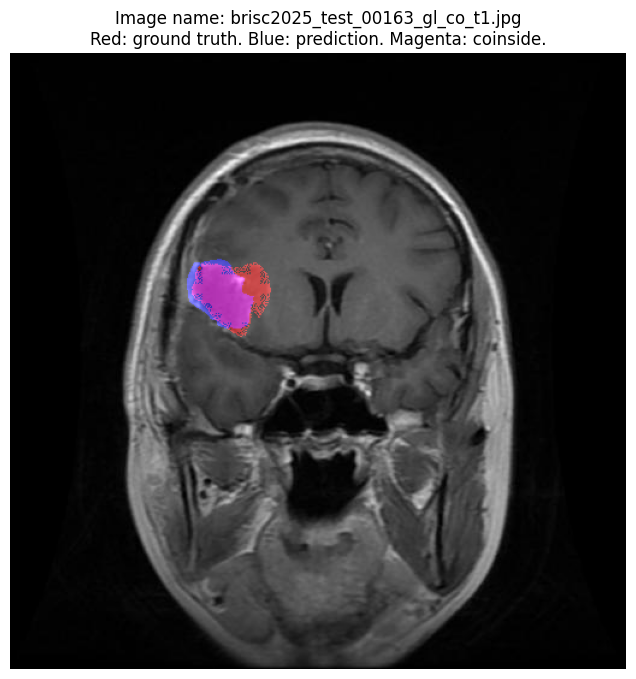



Date 14.08.2025: wrong prediction example.

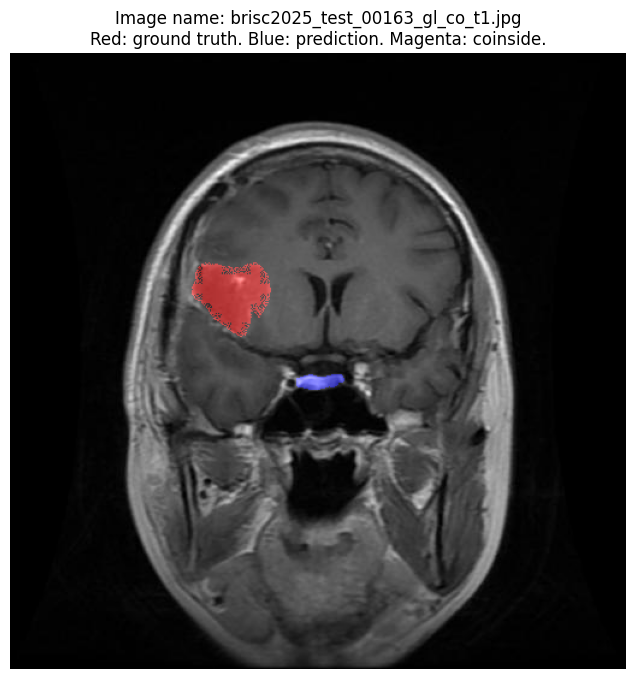

## Results log

### BRISC 2025]

For [BRISC 2025](https://www.kaggle.com/datasets/briscdataset/brisc2025) dataset.

Date 12.08.2025:

    After 9 epochs.
    Got accuracy: 98.97%
    My Dice-score: 78.91%

Date 14.08.2025:

    After 14 epochs.
    My Dice-score: 80.94%

<br />

[Brain Tumor Segmentation with Unet](https://www.kaggle.com/code/nirmalgaud/brain-tumor-segmentation-with-unet) has Dice-score: **68.43%**

[Brain Tumor Segmentation with Wavelet](https://www.kaggle.com/code/nirmalgaud/brain-tumor-segmentation-with-wavelet) has Dice-score: **78.40%**

### Carvana Image Masking Challenge

For [Carvana Image Masking Challenge](https://www.kaggle.com/competitions/carvana-image-masking-challenge) dataset.

    After 6 epochs.
    Got 1833077 / 1843200 with accuracy 99.45%
    My Dice-score: 98.799%

**Best** Kaggle Dice-score: 99.734%

## Save results to Google Drive

In [ ]:
pictures_dir = os.path.dirname(data_dir) + '/pictures'
print(pictures_dir)

!cp -rf "{CHECKPOINT_FILE}"             "{data_dir}"
!cp -rf "{MODEL_NAME}_score_plot.png"   "{pictures_dir}"
!cp -rf "{MODEL_NAME}_loss_plot.png"    "{pictures_dir}"

/content/gdrive/My Drive/Colab Notebooks/2025.07.25_execises/pictures


## Automatically clean up all resources

In [ ]:
# # Clean up resources. Place this code at the end of the program.
# import os, signal
# os.kill(os.getpid(), signal.SIGTERM)  # you can use signal.SIGKILL for Linux, but not for Windows